In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv('expenses.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [4]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [5]:
# categorical and numerics features
categorical = df.select_dtypes(include = object).columns
numeric = df.select_dtypes(exclude = object).columns
categorical, numeric

(Index(['sex', 'smoker', 'region'], dtype='object'),
 Index(['age', 'bmi', 'children', 'charges'], dtype='object'))

In [6]:
# unique values
unique_val = dict()
for c in categorical:
    print(c)
    print(df[c].value_counts().head())
    print('-'*10)
    
    unique_val[c] = list( df[c].unique() )
unique_val

sex
male      676
female    662
Name: sex, dtype: int64
----------
smoker
no     1064
yes     274
Name: smoker, dtype: int64
----------
region
southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64
----------


{'sex': ['female', 'male'],
 'smoker': ['yes', 'no'],
 'region': ['southwest', 'southeast', 'northwest', 'northeast']}

In [7]:
#categorical and numerics features
feat_cat = df.select_dtypes(include = object).columns
feat_num = df.select_dtypes(exclude = object).columns
feat_cat, feat_num

(Index(['sex', 'smoker', 'region'], dtype='object'),
 Index(['age', 'bmi', 'children', 'charges'], dtype='object'))

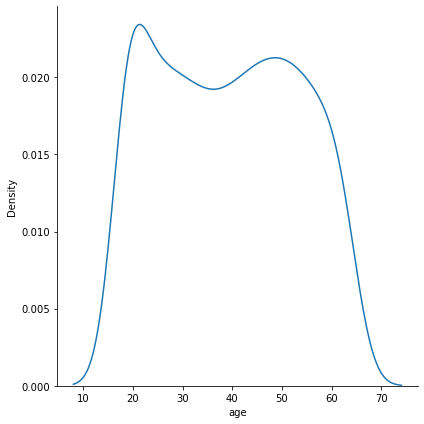

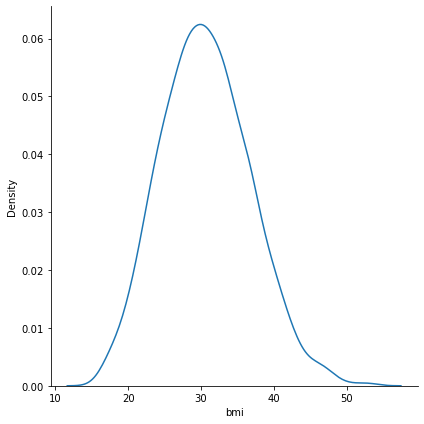

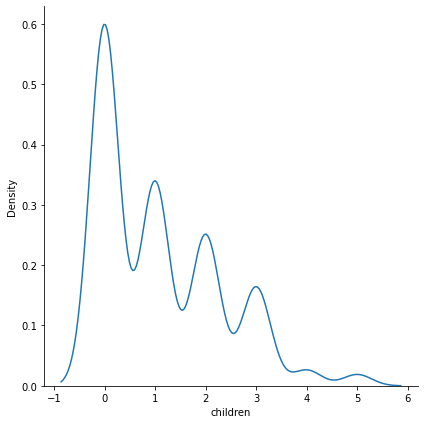

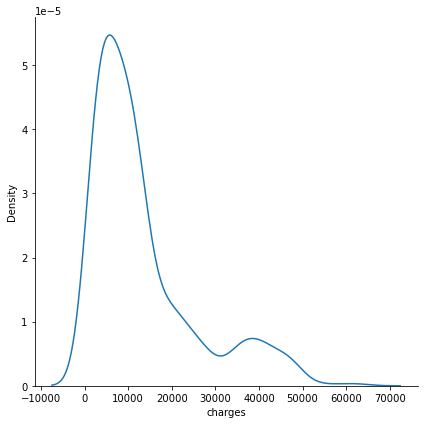

In [8]:
#only BMI has a normal distribution
for f in feat_num:
  sns.displot(data = df, x = f, kind = 'kde', height = 6);

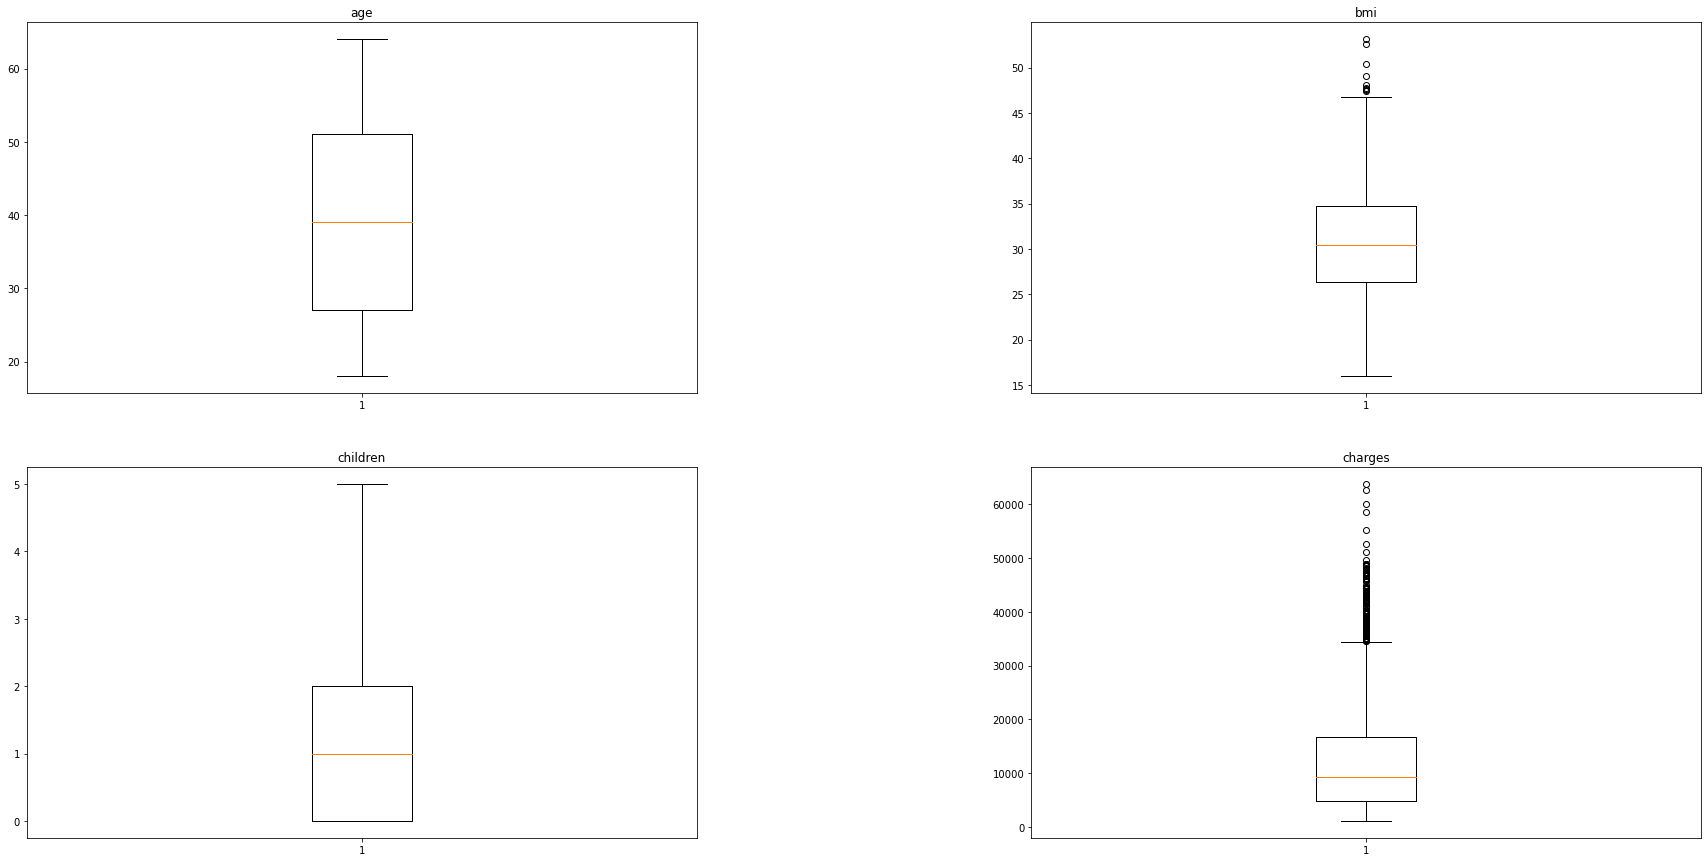

In [9]:
# look at outliers
## there are many in charges and some in bmi
rows, columns = 2, 2
fig, axes = plt.subplots(rows, columns, figsize=(30, 15))
axes = axes.ravel()
for i in range(rows*columns):
    column = feat_num[i]
    axes[i].boxplot(df[column])
    axes[i].set_title(column)
plt.subplots_adjust(wspace = 0.5)

In [10]:
# Multicollinearity
## age and BMI seem corrilated and childen does not
features = feat_num[:-1] # Exclude target

vif = pd.DataFrame()
vif['feature'] = features
vif["VIF"] = [variance_inflation_factor(df[features].values, i) for i in range(len(features))]
vif

,feature,VIF
0,age,7.536550
1,bmi,7.846515
2,children,1.796637


In [11]:
bmi_status = list()
for bmi in df['bmi'].values:
    bmi_status.append( 'underweight' if bmi < 18.5 else 'normal weight' if bmi < 25 else 'overweight' if bmi < 30 else 'obesity' )
df['bmi_status'] = bmi_status
df.head()

,age,sex,bmi,children,smoker,region,charges,bmi_status
0,19,female,27.900,0,yes,southwest,16884.92400,overweight
1,18,male,33.770,1,no,southeast,1725.55230,obesity
2,28,male,33.000,3,no,southeast,4449.46200,obesity
3,33,male,22.705,0,no,northwest,21984.47061,normal weight
4,32,male,28.880,0,no,northwest,3866.85520,overweight


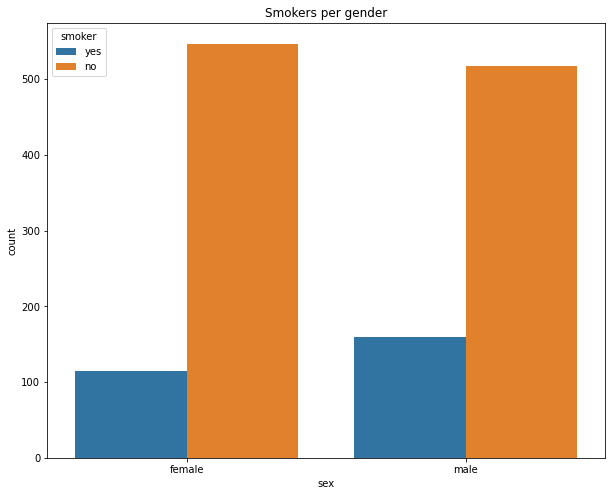

In [12]:
plt.figure(figsize = (10, 8))
plt.title('Smokers per gender')
ax = sns.countplot(x="sex", hue="smoker", data=df);

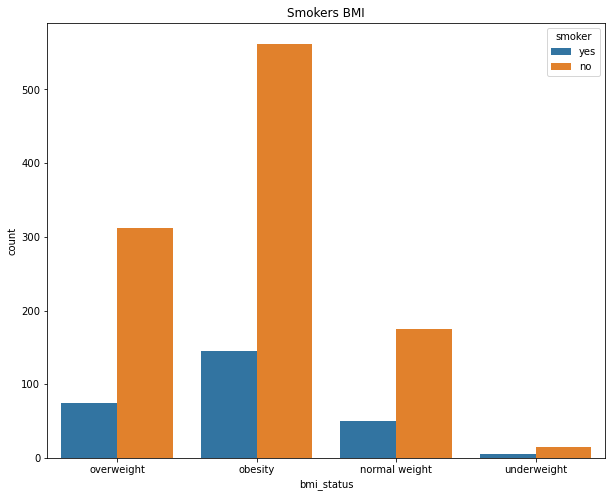

In [13]:
plt.figure(figsize = (10, 8))
plt.title('Smokers BMI')
ax = sns.countplot(x="bmi_status", hue="smoker", data=df);

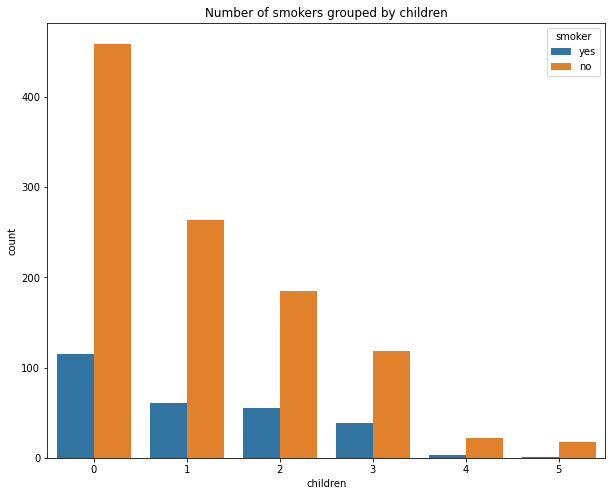

In [14]:
plt.figure(figsize = (10, 8))
plt.title('Number of smokers grouped by children')
ax = sns.countplot(x="children", hue="smoker", data=df);

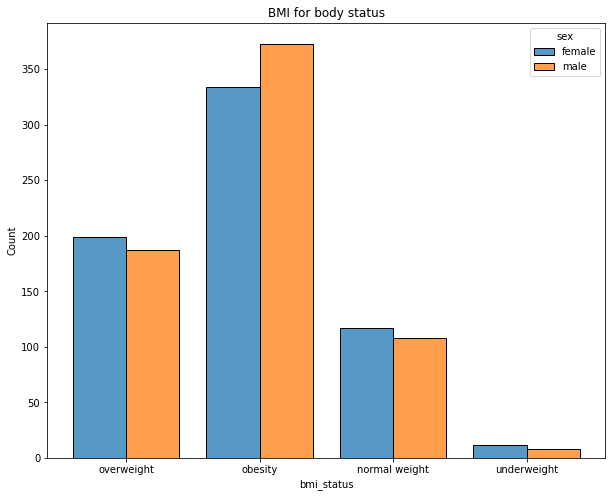

In [15]:
plt.figure(figsize = (10, 8))
plt.title('BMI for body status')
sns.histplot(data=df, x="bmi_status", multiple="dodge", hue="sex", shrink=.8); 

Text(0.5, 1.0, 'smoker')

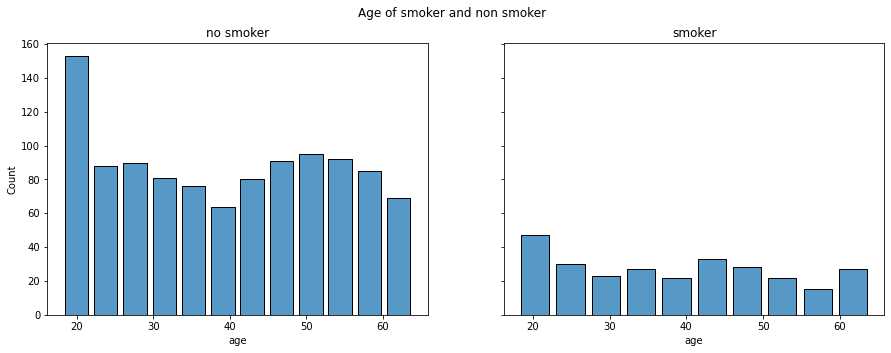

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
fig.suptitle('Age of smoker and non smoker')

# no smoker
sns.histplot(data=df[df['smoker'] == 'no'], x="age", multiple="dodge", shrink=.8, ax=axes[0]);
axes[0].set_title('no smoker');
# smoker
sns.histplot(data=df[df['smoker'] == 'yes'], x="age", multiple="dodge", shrink=.8, ax=axes[1]);
axes[1].set_title('smoker')

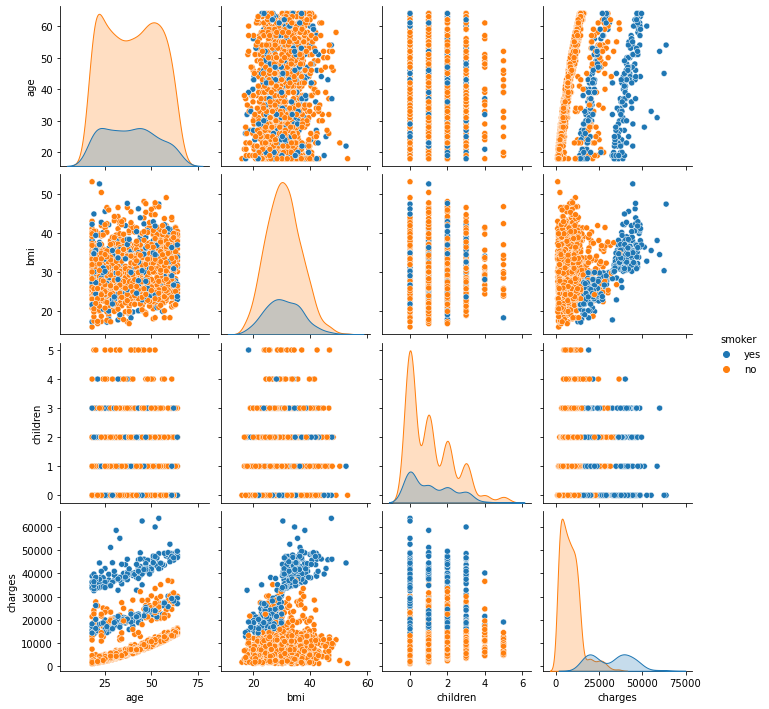

In [27]:
sns.pairplot(df, hue = 'smoker')

In [17]:
X, y = df.drop(['charges', 'bmi_status'], axis = 1), df['charges']
X.shape, y.shape

((1338, 6), (1338,))

In [18]:
feat_cat = list( X.select_dtypes(include = object).columns )
feat_num = list( X.select_dtypes(exclude = object).columns )

In [19]:
def get_df_pred(y_test, y_pred):
    data = []
    for t, p in zip(y_test.array, y_pred):
      data.append( (int(t), int(p)) )

    return pd.DataFrame(data, columns = ('Test', 'Pred'))

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state = 14)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((936, 6), (402, 6), (936,), (402,))

In [21]:
X_train.head()

,age,sex,bmi,children,smoker,region
673,41,female,31.02,0,no,southeast
163,32,female,29.80,2,no,southwest
1101,53,male,28.60,3,no,southwest
794,39,female,31.92,2,no,northwest
382,55,male,33.00,0,no,southeast


In [22]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [23]:
params_tree = {'classifier__criterion': ('squared_error', 'friedman_mse', 'absolute_error', 'poisson'),
              'classifier__splitter': ('best', ),
              'classifier__min_samples_split': (2, 3, 5, 8, 13),
              'classifier__min_samples_leaf': (1, 2, 3, 5, 8),
              'classifier__max_features': ('auto', 'sqrt', 'log2')}

In [24]:
numeric_transformer  = Pipeline(steps = [('imputer', SimpleImputer())])
numeric_transformer2 = Pipeline(steps = [('minmax', MinMaxScaler())])

In [25]:
params_forest = {'classifier__n_estimators': (21, 34, 55, 89, 100, 144),
                'classifier__criterion': ('squared_error', 'absolute_error', 'poisson'),
                'classifier__min_samples_split': (2, 3, 5, 8),
                'classifier__min_samples_leaf': (1, 2, 3, 5),
                'classifier__max_features': ('sqrt', 'log2'),
                'classifier__oob_score': (True,False)
                }

In [ ]:
params_xgbr = {'classifier__booster': ('gbtree', ),
               'classifier__sampling_method': ('uniform', 'subsample', 'gradient_based'),
              'classifier__max_depth': (2, 5, 8, 13),
              'classifier__learning_rate': (.1, .3, .5, .8),              
              'classifier__min_child_weight': (1,3,5),
              'classifier__max_delta_step': (0,1,3),
              'classifier__subsample': (.5, 1)}